## Pulse Train Gating:
    Read in an audio file
    Gate the Pulses
    Plot 1 
    Plot multiple

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import sys
import struct
import scipy
import scipy.signal 
import scipy.io
import scipy.io.wavfile
import math
import sklearn.preprocessing as sk

%matplotlib inline



<class 'numpy.ndarray'>
UnitSignal = [0.         0.98227416 0.92970788 ... 0.         0.         0.        ]


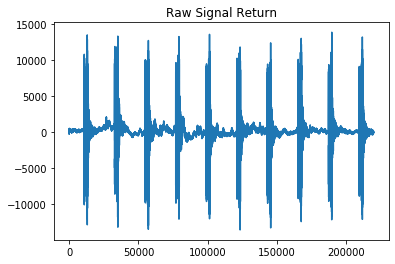

In [2]:

rawAudio = wave.open('output.wav', 'r')
unitSignal = scipy.io.wavfile.read('UnitChirp_2k-4k.wav')
#kernel = wave.open('UnitChirp_2k-4k.wav', 'r')

unitSignal = unitSignal[1]

print(type(unitSignal))
print(f"UnitSignal = {unitSignal}")
kernel = np.trim_zeros(unitSignal, 'fb')


# Extract Raw Audio from Wav File

signal = rawAudio.readframes(-1)
#print(signal)
signal = np.frombuffer(signal, dtype = "int16")
#signal = struct.unpack('h', 0)

# Use the below to get rid of the weird negative peak at the begining.
#signal = signal[340:]

# If Stereo
if rawAudio.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)

signal = signal[500:]
plt.figure(1)
plt.title("Raw Signal Return")
plt.plot(signal)
plt.show()



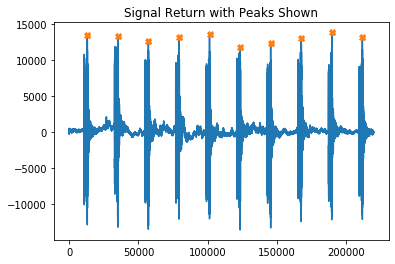

[ 13051  35110  57169  79228 101287 123346 145405 167464 189523 211582]


In [3]:
# Find Peaks to determine the PRI and how large of a Gate to use.
audioPeaks = scipy.signal.find_peaks(signal, height = 10000, distance =2500)[0]

plt.figure(1)
plt.title("Signal Return with Peaks Shown")
plt.plot(signal)
plt.plot(audioPeaks, signal[audioPeaks], "X")
#plt.scatter(audioPeaks)
plt.show()

print(audioPeaks)

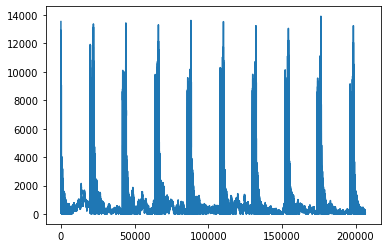

In [4]:
# Shift Signal so that the first peak occures at t = 0.
rolledSignal = signal[audioPeaks[0]:]

# Take the Absolute value of the signal
rolledSignal = abs(rolledSignal)
plt.figure(1)
plt.plot(rolledSignal)
plt.show()

In [5]:
# Figure out the average PRI from the average delta between peaks.
added = 0
print(audioPeaks)

for i in range((len(audioPeaks))):
    if i == 0: continue
    diff = (audioPeaks[i] - audioPeaks[i-1])
    added = added + diff
    #print(i)
    
averagePRI = added / (len(audioPeaks) - 1)
#print(f"Average Time Samples Between Peaks: {averagePRI}")  
#print(averagePRI)
averagePRI = int(round(averagePRI, 0))
print(round(averagePRI))

[ 13051  35110  57169  79228 101287 123346 145405 167464 189523 211582]
22059


[     0  22059  44118  66177  88236 110295 132354 154413 176472 198531]
0
1
2
3
4
5
6
7
8


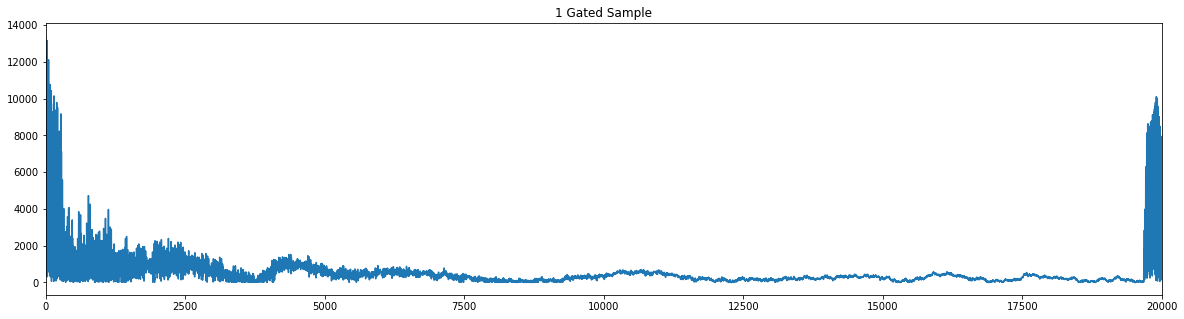

In [6]:
# Starting to Gate:

gatedSample = []
#averagePRI = 25059
gateLengths = np.arange(0,(averagePRI*10), averagePRI)
print(gateLengths)


for i in range((len(gateLengths)-1)):
    print(i)
    gatedSample.append(rolledSignal[gateLengths[i]:gateLengths[i+1]])

gatedSample = np.array(gatedSample)

plt.figure(figsize=(20, 5))
plt.title("1 Gated Sample")
#plt.semilogy(gatedSample[0])
plt.plot(gatedSample[1])
plt.xlim(0, 20000)
plt.show()
#print(f"gatedSamples = {gatedSample}")



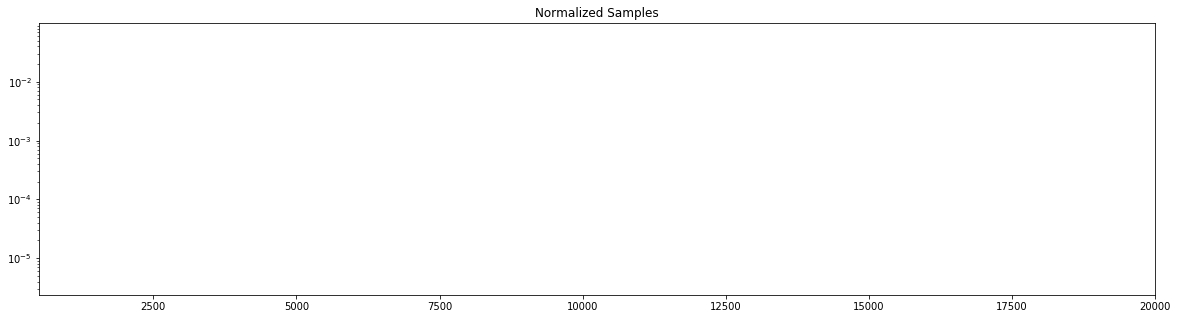

In [7]:
# Normalizing
normalizedSample = sk.normalize(gatedSample, norm = 'l2')

plt.figure(figsize=(20, 5))
plt.title("Normalized Samples")
plt.semilogy(normalizedSample)
#plt.plot(normalizedSample)
plt.xlim(500, 20000)
plt.show()

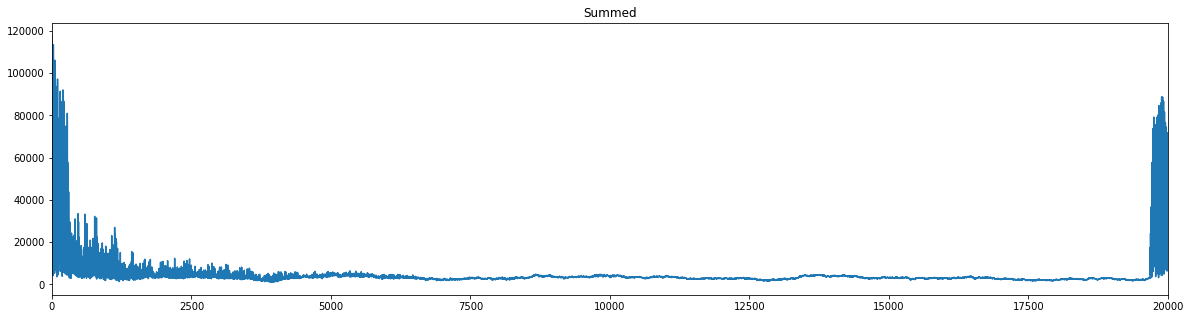

In [8]:
# Adding the samples.

multiSample = np.sum(gatedSample, axis = 0)
plt.figure(figsize=(20, 5))
plt.title("Summed")
#plt.semilogy(gatedSample[0])
plt.plot(multiSample)
plt.xlim(0, 20000)
plt.show()

Kernel = [ 0.98227416  0.92970788  0.84414067 ... -0.68271282 -0.50147854
 -0.29465861]
(22059,)
(4857,)


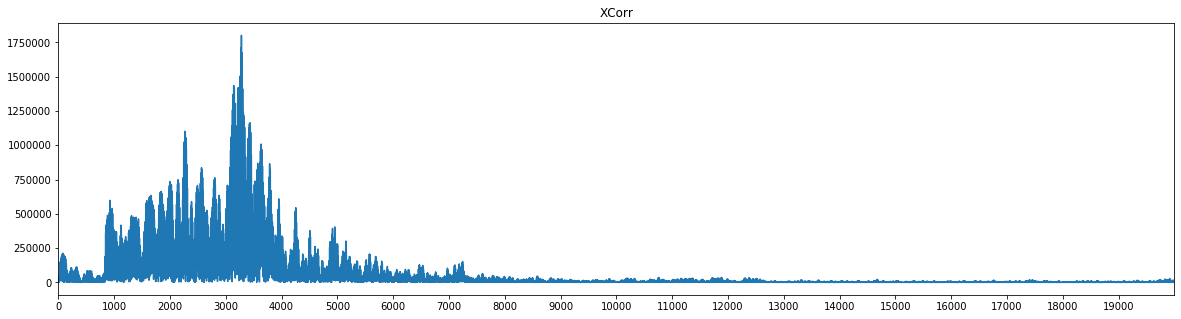

In [9]:
#print(type(multiSample))
print(f"Kernel = {kernel}")
print(np.shape(multiSample))
print(np.shape(kernel))

# Filtering
#b, a = scipy.signal.butter(5, [1500, 2500], btype = 'band')
fs = 44100
lowcut = 1800
highcut = 4400
order = 5

nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
b, a = scipy.signal.butter(order, [low, high], btype='band')

filteredSample = scipy.signal.lfilter(b, a, multiSample)

correlatedSignal = abs(scipy.signal.correlate(filteredSample, kernel, 'full'))


plt.figure(figsize=(20, 5))
plt.title("XCorr")
plt.plot(correlatedSignal)
plt.xlim(0, 20000)
plt.xticks(np.arange(0, 20000, 1000))
plt.show()



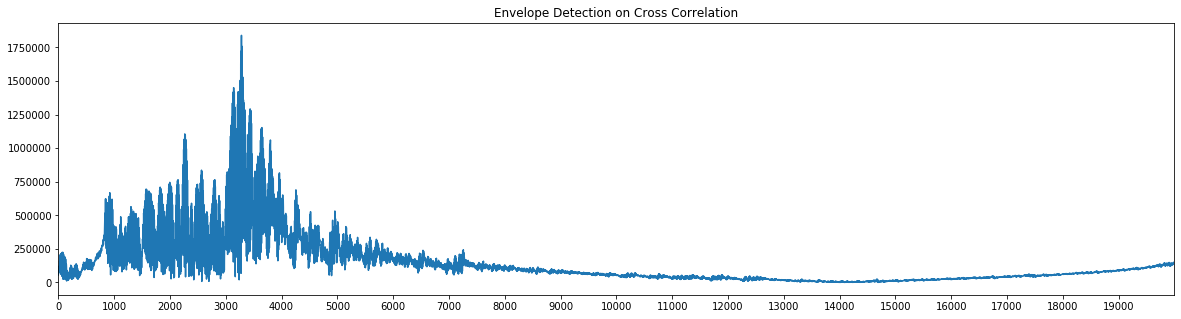

In [10]:
import scipy.signal


# Envelope Detection

signalAnalysis = scipy.signal.hilbert(correlatedSignal)
envelopeDetection = abs(signalAnalysis)

plt.figure(figsize=(20, 5))
plt.title("Envelope Detection on Cross Correlation")
plt.plot(envelopeDetection)
plt.xlim(0, 20000)
plt.xticks(np.arange(0, 20000, 1000))
plt.show()

In [11]:
# Distance Math
# Sample rate of 44100 Samples per Second
# 43 feet to target.
peak = int(input("Where is a peak observed? (sample number) "))
v = 343 #m/s
feet = 43
meters = feet * 0.3048
meters

secPsample = 1/44100
mPsample = secPsample * v
distanceM = (mPsample*peak)/2 # "There and Back Again" -Bilbo Baggins
distanceM

Where is a peak observed? (sample number) 3400


13.222222222222221

In [12]:
# Sum the samples before doing an envelope
# Envelope / FM Chirp min...
#
# Dont envelope before cross correlating
#
# Plot the FFT before applying filter
# Apply the filter.
# Then Plot the FFT again, to ensure the filter is helping.

# Scipy.correlate(kernel, signal)